In [176]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import six

  Using cached https://files.pythonhosted.org/packages/a8/76/220ba4420459d9c4c9c9587c6ce607bf56c25b3d3d2de62056efe482dadc/seaborn-0.9.0-py3-none-any.whl
Could not install packages due to an EnvironmentError: [Errno 13] Permission denied: '/Users/tranduythanh/Library/Python/3.7/lib'
Check the permissions.

You are using pip version 19.0.2, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [465]:
newest_data = pd.read_csv("datasets/20190920/detail_2019-09-16_2019-09-19-newest.csv")
newest_data.head(1)

order_id                course_id level  \
0  5d7e6e297372fc002b50e900  Combo_HienNT.01_TuHK.01   L7A   

                       l1_at                  staff_id    rank  \
0  2019-09-16 07:00:27 +0700  5bbf18460dcc80000bdc6092  0.2498   

                  created_at group_piority  group_query_rank  group_rank_sale  \
0  2019-09-16 00:00:25 +0700           low           0.22612          0.08257   

          staff_email  
0  hiendt8@edumall.vn

In [485]:
def ranking_sale_normailize(df):
    tmp = df[~df["group_rank_sale"].isnull()].groupby("course_id").agg({"group_rank_sale": ["mean", "min", "max"]})
    tmp.columns = ['group_rank_sale_mean', 'group_rank_sale_min', 'group_rank_sale_max']
    tmp = tmp.reset_index()
    
    joined_df = df.merge(tmp, on="course_id", how="left")
    joined_df = joined_df.rename(columns={"group_rank_sale": "group_rank_sale_original"})
    joined_df["group_rank_sale"] = (joined_df["group_rank_sale_original"] - joined_df["group_rank_sale_min"])/ (joined_df["group_rank_sale_max"] - joined_df["group_rank_sale_min"])
        
    return joined_df
normalized_df = ranking_sale_normailize(newest_data)

In [456]:
def plot_table(table_df):
    plt.figure(figsize=(16, 8))
    # Get some pastel shades for the colors
    columns = table_df.columns.values
    rows = table_df.index.values
    data = table_df.values
    colors = plt.cm.BuPu(np.linspace(0, 3, len(rows)))
    print(colors)
    n_rows = len(data)

    index = np.arange(len(columns)) + 0.3
    bar_width = 0.4

    # Initialize the vertical-offset for the stacked bar chart.
    y_offset = np.zeros(len(columns))

    # Plot bars and create text labels for the table
    cell_text = []
    for row in range(n_rows):
        plt.bar(index, data[row], bar_width, bottom=y_offset, color=colors[row])
        y_offset = y_offset + data[row]
        cell_text.append(['%1.1f' % (x / 1000.0) for x in y_offset])
    # Reverse colors and text labels to display the last value at the top.
    colors = colors[::-1]
    cell_text.reverse()

    # Add a table at the bottom of the axes
    the_table = plt.table(cellText=cell_text,
                          rowLabels=rows,
                          rowColours=colors,
                          colLabels=columns,
                          loc='bottom')

    # Adjust layout to make room for the table:
    plt.subplots_adjust(left=0.2, bottom=0.2)

    plt.ylabel("Ranking Sale")
    plt.xlabel("Ranking C3")
    plt.title('Ranking C3 by Ranking Sale')

    plt.show()

In [494]:
def export(df, c3_bins=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8], 
           sale_bins = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]):
    df["is_l3"] = 1
    df["is_l3"][(df["level"] == "L1")|(df["level"] == "L2")] = 0
    df["rank_category"] = pd.cut(df["rank"], bins=c3_bins)
    df['rank_category'] = df['rank_category'].apply(lambda k: k.right)
    
    
    df["sale_category"] = pd.cut(df["group_rank_sale"], bins=sale_bins)
    df['sale_category'] = df['sale_category'].apply(lambda k: k.right)
    
    def aggfunc(x):
        return round(x, 2)
    
    def bar_chart(df, df_percentage, label="Number of contacts in group ranking c3", xlabel="Ranking Sales", is_plot=False):
        fig, host = plt.subplots(figsize=(16, 8))
        ax  = plt.gca()
        total = df.sum(axis=0).reset_index()
        total = total.rename(columns={0: "total"})
        rows = df_percentage.shape[0]
        ax.bar(total.index, total.iloc[:, -1], edgecolor='black')
        colors = ["#FFCCCC", "#FF9999", "#FF6666", "#FF3399", "#FF0000", "#CC0000", "#990000", "#660000", "#330000", "#000000", "blue", "green", "cyan", "magenta", "pink", "brown", "purple", "red", "gray", "black"]
        y_offset = np.zeros(len(total.index.values))
        ranking_c3 = df_percentage.index.values
        bar_width = 0.75

        # Plot bars and create text labels for the table
        cell_text = []
        for row in range(rows-1, -1, -1):
            heights = df.iloc[row, :].values
            plt.bar(total.index, df.iloc[row, :], bottom=y_offset, color=colors[row], label=f"{label} = {ranking_c3[row]}", edgecolor="black")
            if is_plot:
                plt.bar(total.index, np.multiply(df_percentage.iloc[row, :].values, heights), 0.7, bottom=y_offset, color="yellow", edgecolor="black")
            y_offset = y_offset + heights
        
        if is_plot:
            plt.bar(total.index, np.zeros(df_percentage.shape[1]), color="yellow", label=f"The percentage of the converted {label} in each rank group")
        plt.xlabel(xlabel)
        plt.xticks(total.index, total[total.columns.values[0]])
#         handles, labels = ax.get_legend_handles_labels()
#         ax.legend(handles[::-1], labels[::-1])
        plt.legend()
        plt.show()

    def render_mpl_table(data, col_width=3.0, row_height=2.0, font_size=14,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0,
                     ax=None, **kwargs):
        if ax is None:
            size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
            fig, ax = plt.subplots(figsize=size)
            ax = plt.gca()
            ax.set_xlabel("Ranking Sale")
            ax.annotate('Ranking C3', xy=(0, 1), xytext=(-150,-row_height*250), ha='left', va='top', xycoords='axes fraction', textcoords='offset points', fontsize=15,)
            ax.set_xticks([])
            ax.set_yticks([])

        mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, rowLabels=data.index, **kwargs)

        mpl_table.auto_set_font_size(False)
        mpl_table.set_fontsize(font_size)

        for k, cell in  six.iteritems(mpl_table._cells):
            cell.set_edgecolor(edge_color)
            if k[0] == 0 or k[1] < header_columns:
                cell.set_text_props(weight='bold', color='w')
                cell.set_facecolor(header_color)
            else:
                cell.set_facecolor(row_colors[k[0]%len(row_colors) ])
        plt.show()

    num_c3_per_group = df.groupby(["sale_category", 'rank_category'])["order_id"].count().reset_index()
    num_c3_per_group = num_c3_per_group.rename(columns={"order_id": "num_c3"})
    
    num_c3_per_group_pivot = pd.pivot_table(num_c3_per_group, index="rank_category", columns="sale_category", values="num_c3")
    num_c3_per_group_pivot = num_c3_per_group_pivot.fillna(0)
    
    render_mpl_table(num_c3_per_group_pivot)
    
    
    
    converted_l3 = df.groupby(["sale_category", 'rank_category'])["is_l3"].mean().reset_index()
    converted_l3 = converted_l3.rename(columns={"is_l3": "num_l3"})
    
    converted_l3_pivot = pd.pivot_table(converted_l3, index="rank_category", columns="sale_category", values="num_l3", aggfunc=aggfunc)
    converted_l3_pivot = converted_l3_pivot.fillna(0)
    
    render_mpl_table(converted_l3_pivot)
    
    bar_chart(num_c3_per_group_pivot, converted_l3_pivot)
    
    
    
    num_c3_per_group = df.groupby(['rank_category', "sale_category"])["order_id"].count().reset_index()
    num_c3_per_group = num_c3_per_group.rename(columns={"order_id": "num_c3"})
    
    num_c3_per_group_pivot = pd.pivot_table(num_c3_per_group, index="sale_category", columns="rank_category", values="num_c3")
    num_c3_per_group_pivot = num_c3_per_group_pivot.fillna(0)
    
    converted_l3 = df.groupby(['rank_category', "sale_category"])["is_l3"].mean().reset_index()
    converted_l3 = converted_l3.rename(columns={"is_l3": "num_l3"})
    converted_l3_pivot = pd.pivot_table(converted_l3, index="sale_category", columns="rank_category", values="num_l3", aggfunc=aggfunc)
    converted_l3_pivot = converted_l3_pivot.fillna(0)
    
    bar_chart(num_c3_per_group_pivot, converted_l3_pivot, label="Number of sales in group ranking sale", xlabel="Ranking C3")
    
    
    
    

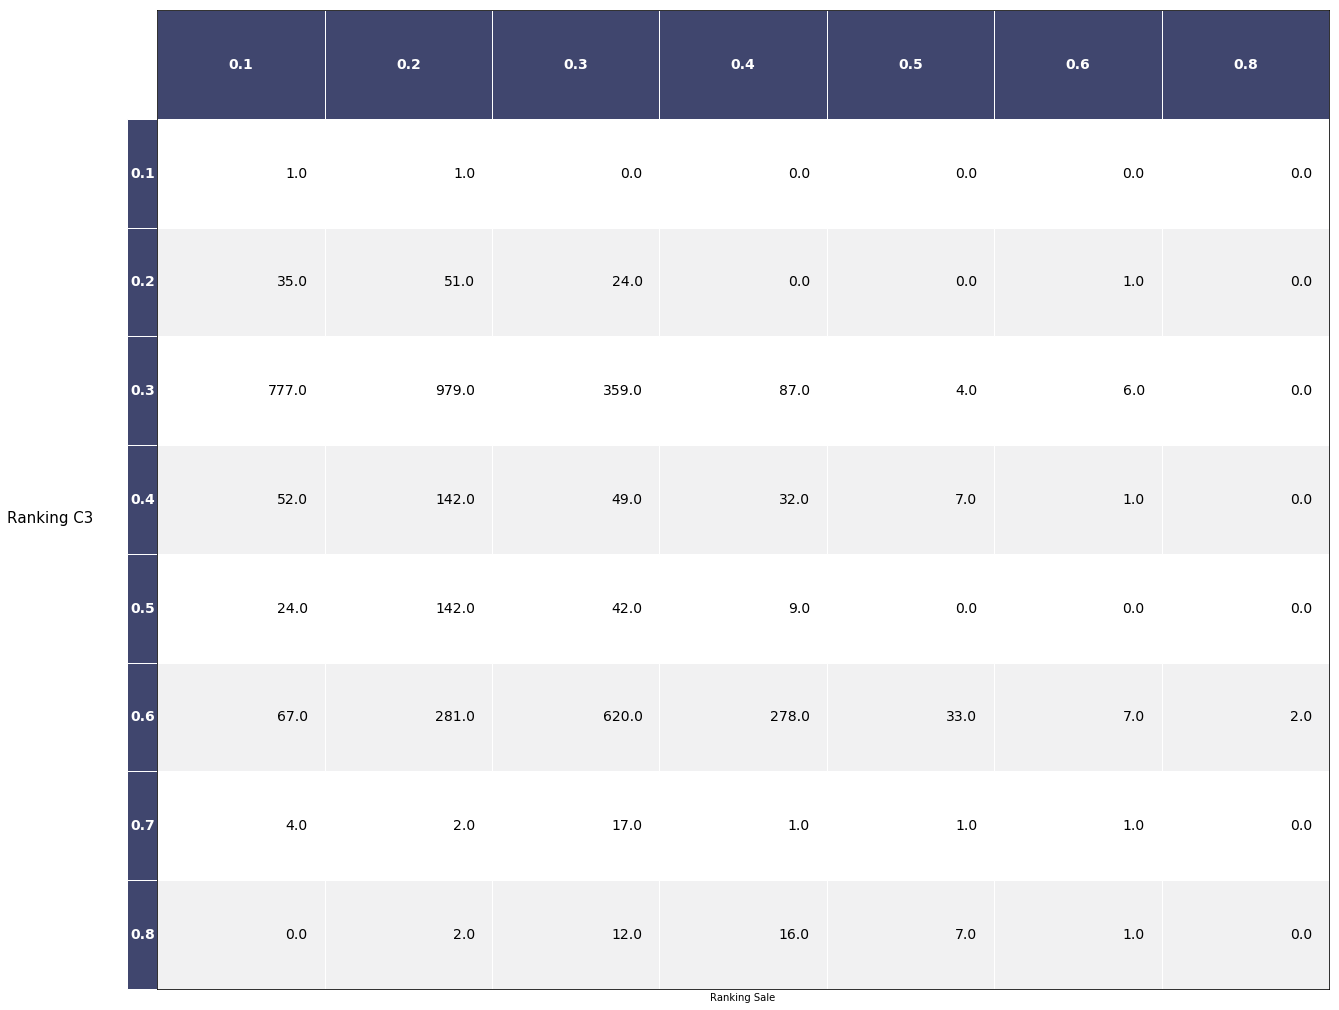

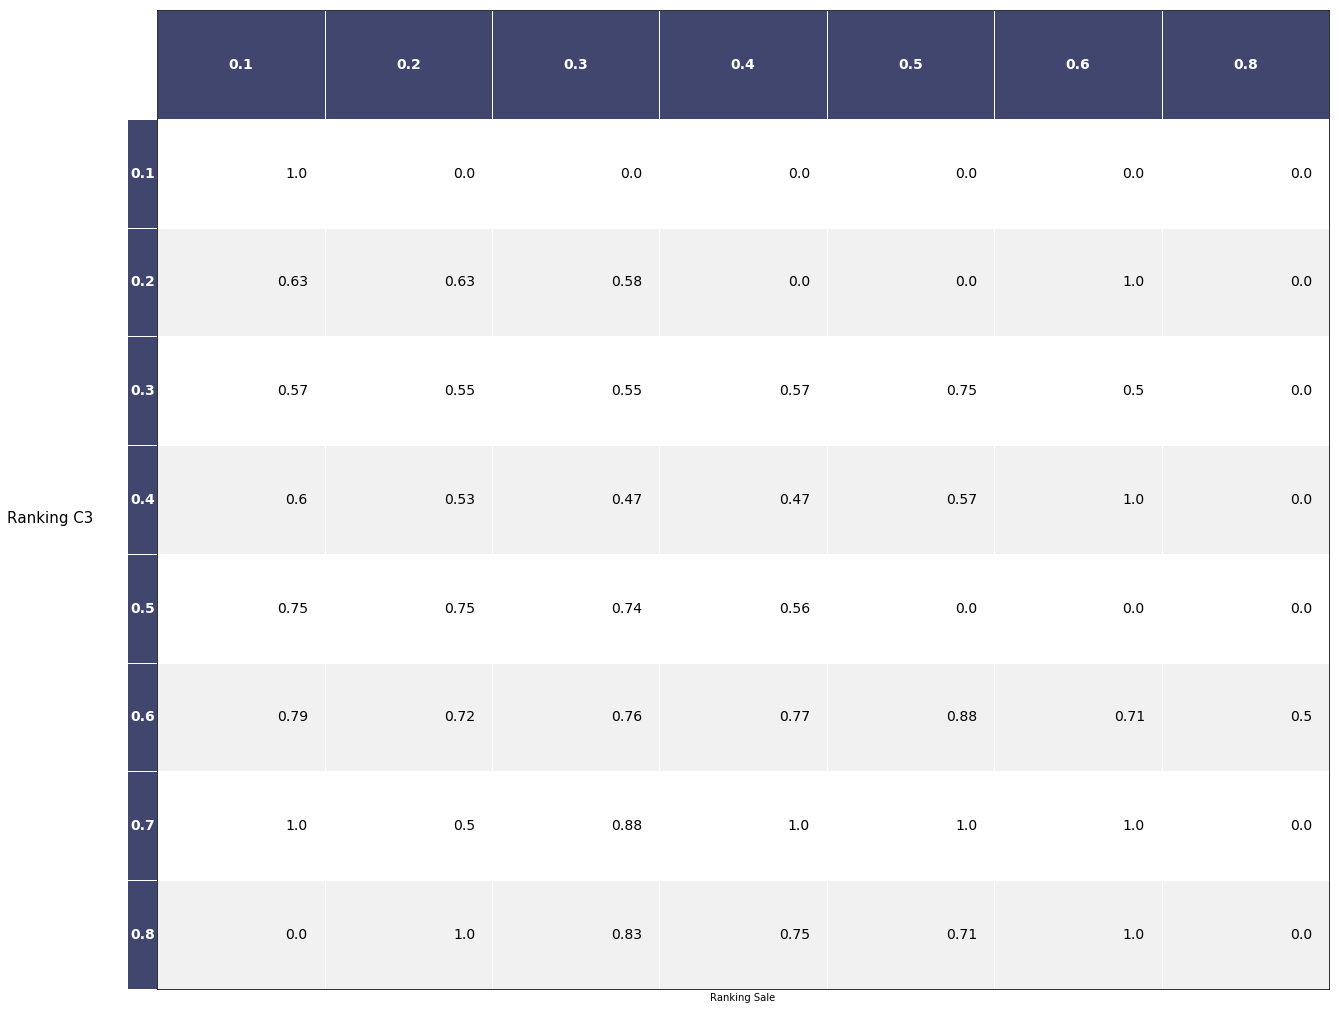

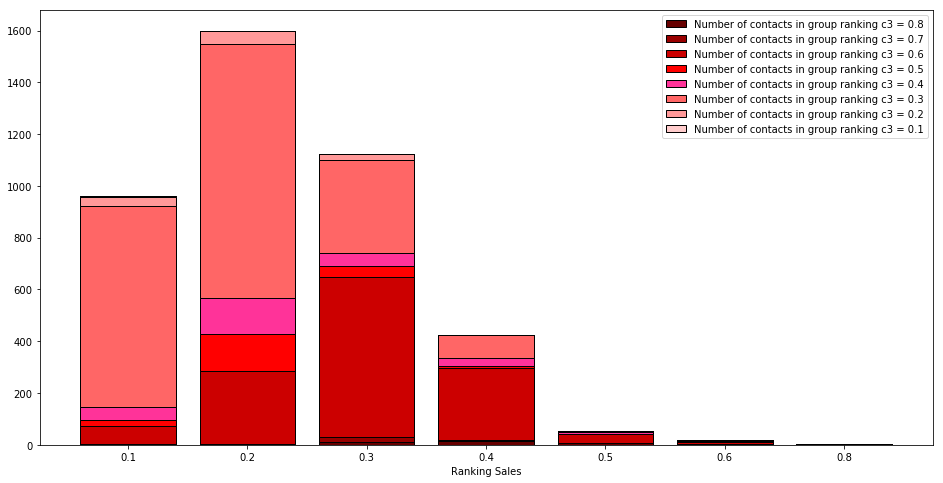

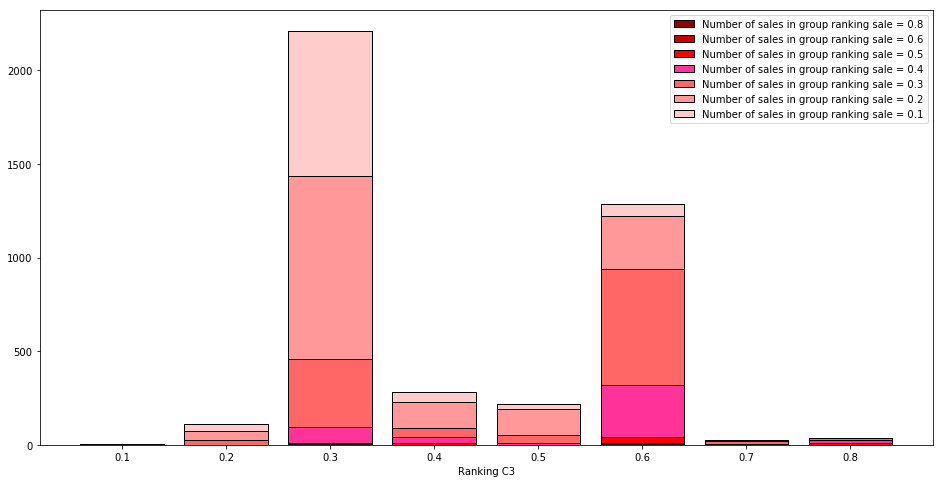

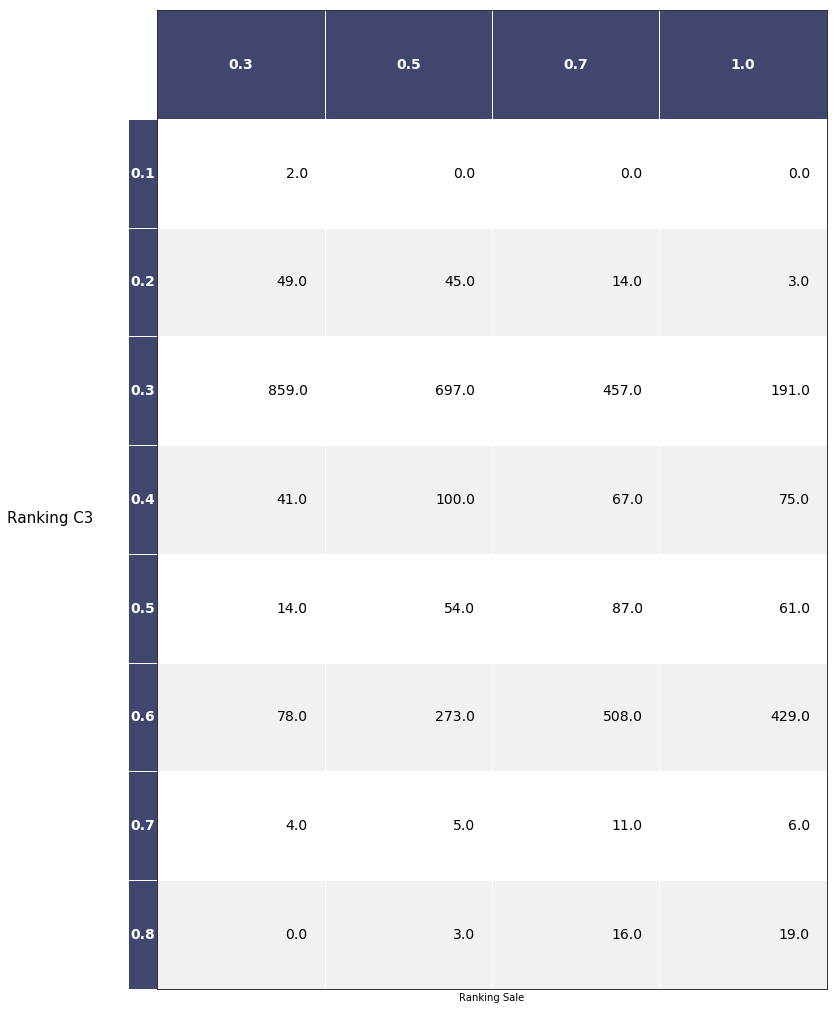

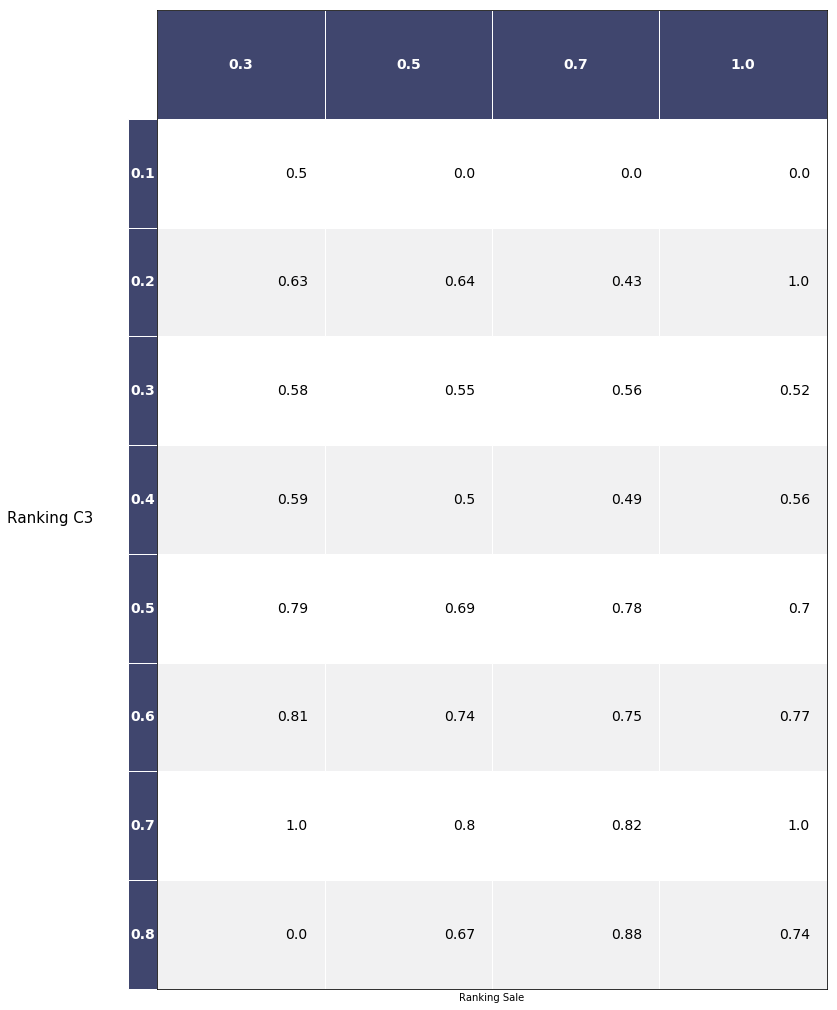

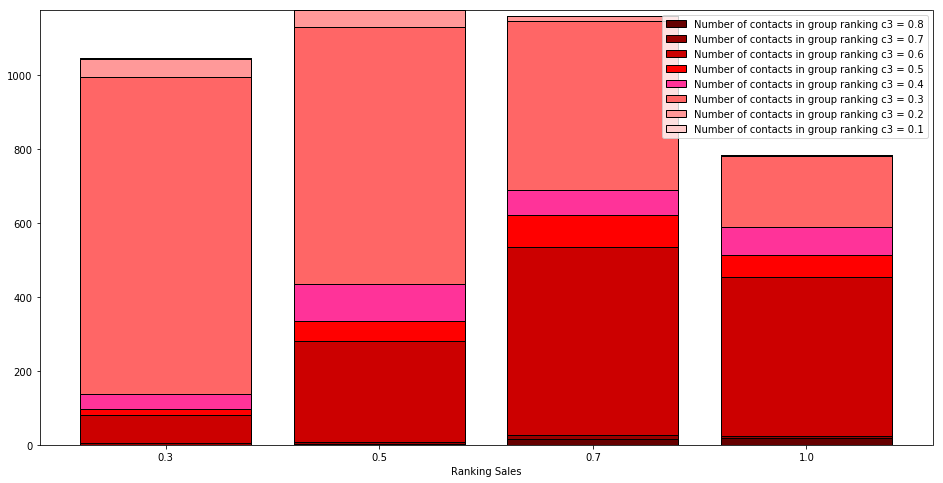

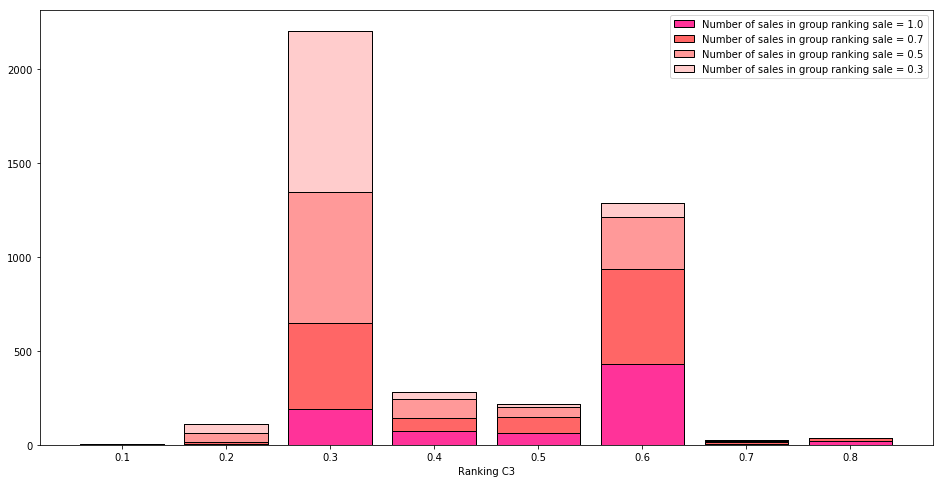

In [495]:
export(newest_data)
export(normalized_df, sale_bins=[0.0, 0.3, 0.5, 0.7, 1])

In [496]:
hungarian = pd.read_csv("datasets/20190920/hungarian.csv")
hungarian.head()

Unnamed: 0      cost                                          course_id  \
0           0 -0.000000                Combo_TranDG.04_HangNTD.03_TungH.01   
1           1  0.036748           Combo_KietDT.01_HanhPT.03_EDG.Nativefree   
2           2 -0.000000     Combo.1_cuongdh.01_luanvh.01_hoangvm.13_YGT.07   
3           3  0.111064          Combo499_CuongBQ.01_CuongDH.03_QuyenVN.01   
4           4  0.045311  combo01_linhvt.01-kietdt.05_hanhpt.02_EDG.nati...   

                  created_at created_date  date group_piority  \
0  2019-09-16 03:40:07+07:00   2019-09-16   NaN           NaN   
1  2019-09-16 03:21:38+07:00   2019-09-16   NaN          high   
2  2019-09-16 03:00:02+07:00   2019-09-16   NaN           NaN   
3  2019-09-16 02:51:37+07:00   2019-09-16   NaN          high   
4  2019-09-16 02:18:21+07:00   2019-09-16   NaN           low   

   group_query_rank  group_rank_sale                      l1_at     l1_date  \
0               NaN              NaN  2019-09-16 07:06:07+07:00  2019-09-16   
1          0.284139         0.132128  2019-09-16 07:12:09+07:00  2019-09-16   
2               NaN              NaN  2019-09-16 07:13:30+07:00  2019-09-16   
3          0.295595         0.207199  2019-09-16 08:20:57+07:00  2019-09-16   
4          0.288208         0.167409  2019-09-16 07:02:42+07:00  2019-09-16   

  level                  order_id      rank          staff_email  \
0    L1  5d7ea1a77372fc002850e8da  0.336108  linhnm88@edumall.vn   
1   L8A  5d7e9d527372fc002850e8d8  0.278122    diunt8@edumall.vn   
2   L8B  5d7e98427372fc002550e8ee  0.313756  linhnm88@edumall.vn   
3   L8A  5d7e96497372fc002850e8d4  0.536025   namnm68@edumall.vn   
4   L8A  5d7e8e7d7372fc002b50e923  0.270659  linhnm88@edumall.vn   

                   staff_id  
0  5d550a6fef786b0001db3c9f  
1  5cf7476564e36d0001932923  
2  5d550abc32e7a10001491e5e  
3  5d108a335c288c0001af70bb  
4  5d1eb89e059c9f000162c424

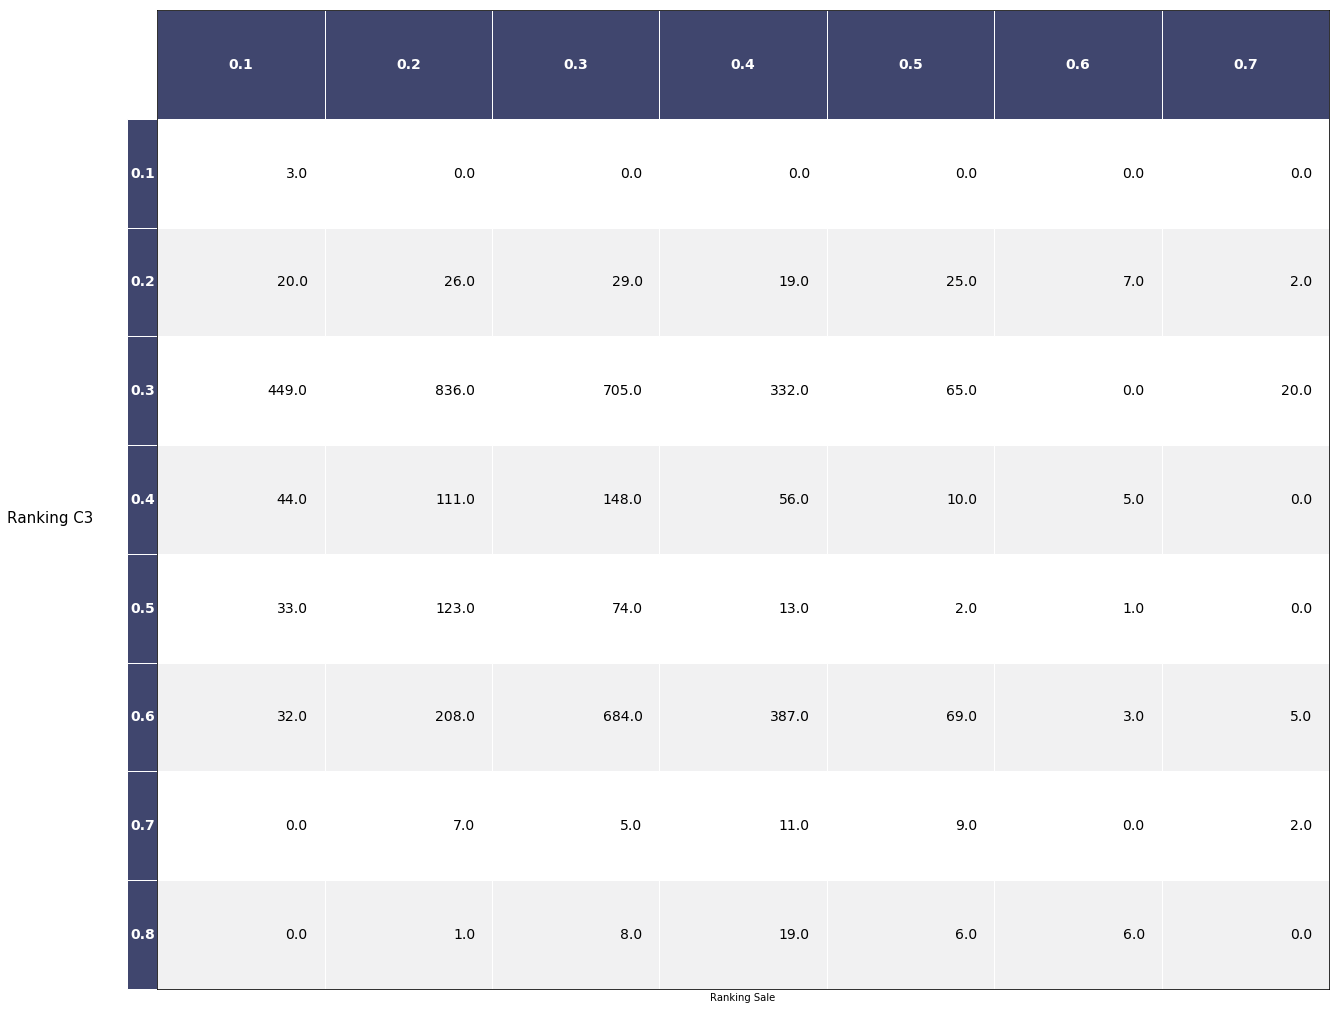

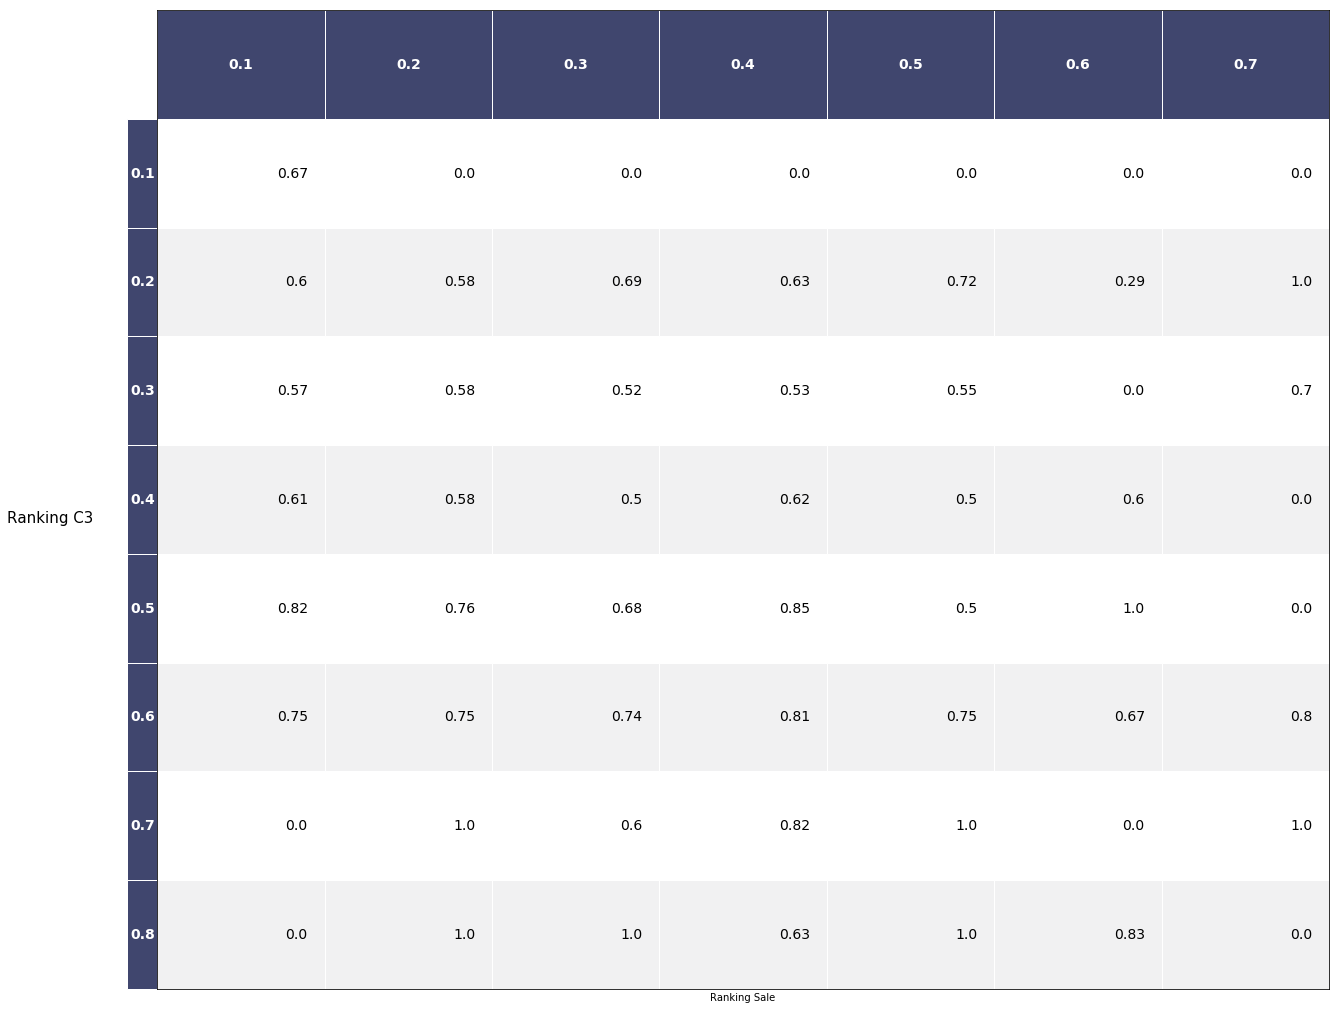

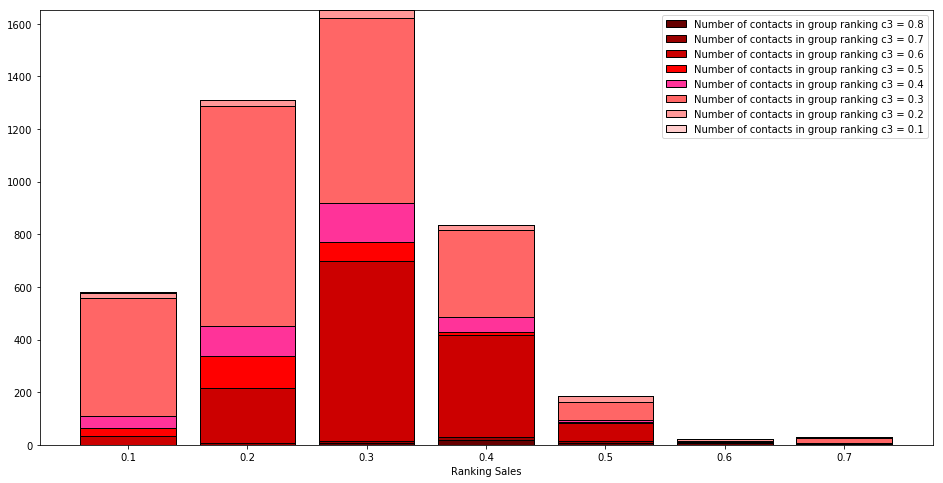

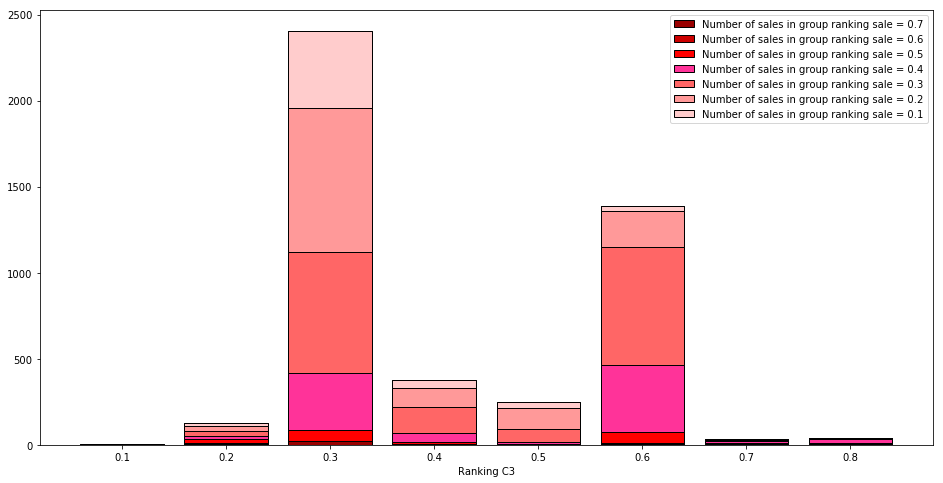

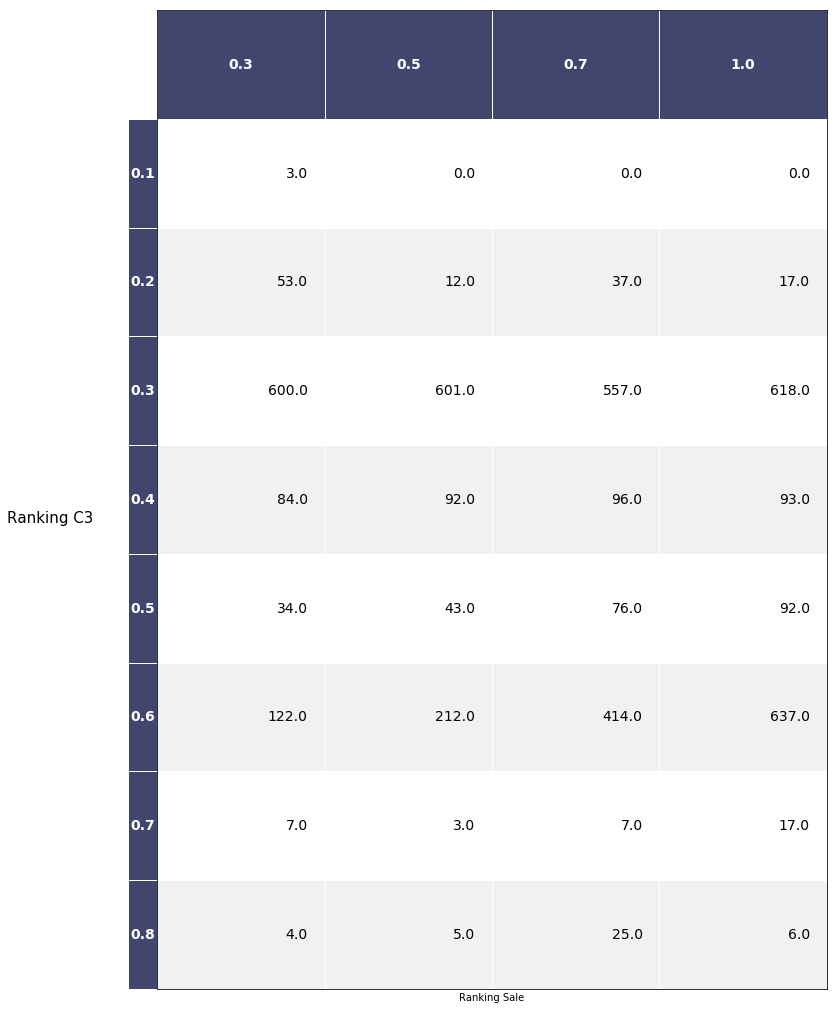

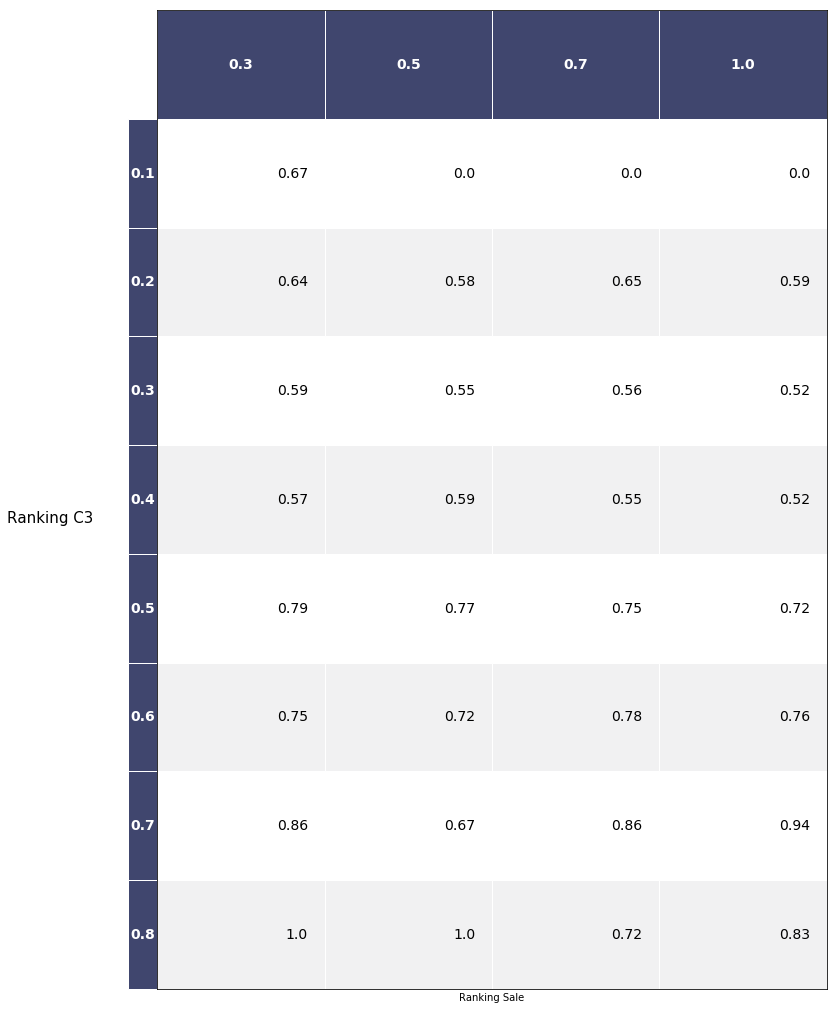

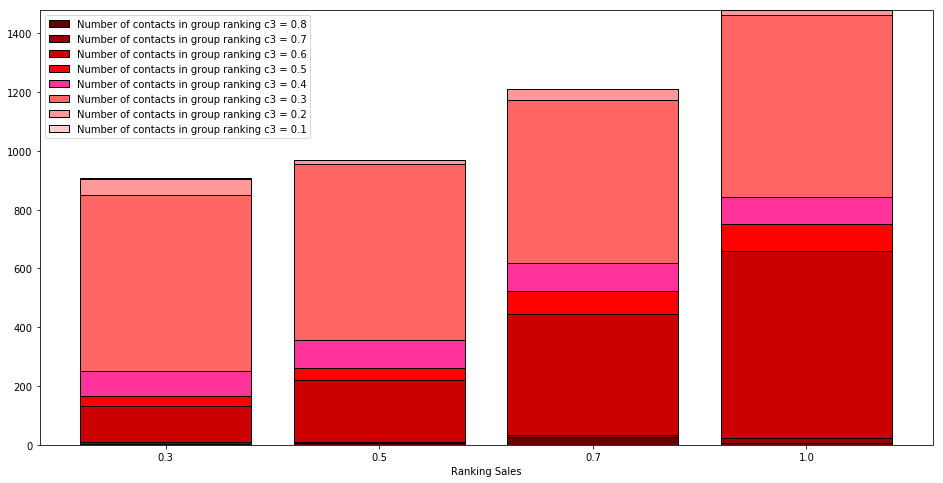

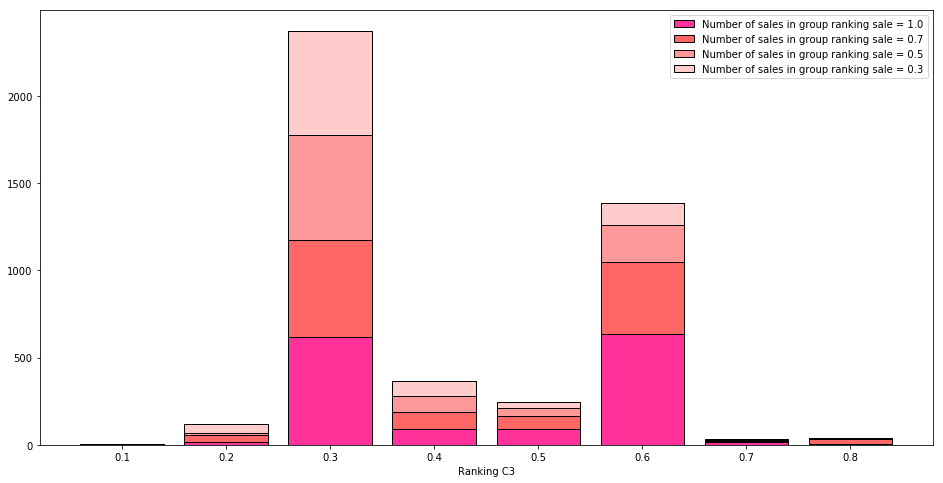

In [497]:
export(hungarian)
normalized_hungarian_df = ranking_sale_normailize(hungarian)
export(normalized_hungarian_df, sale_bins=[0.0, 0.3, 0.5, 0.7, 1])